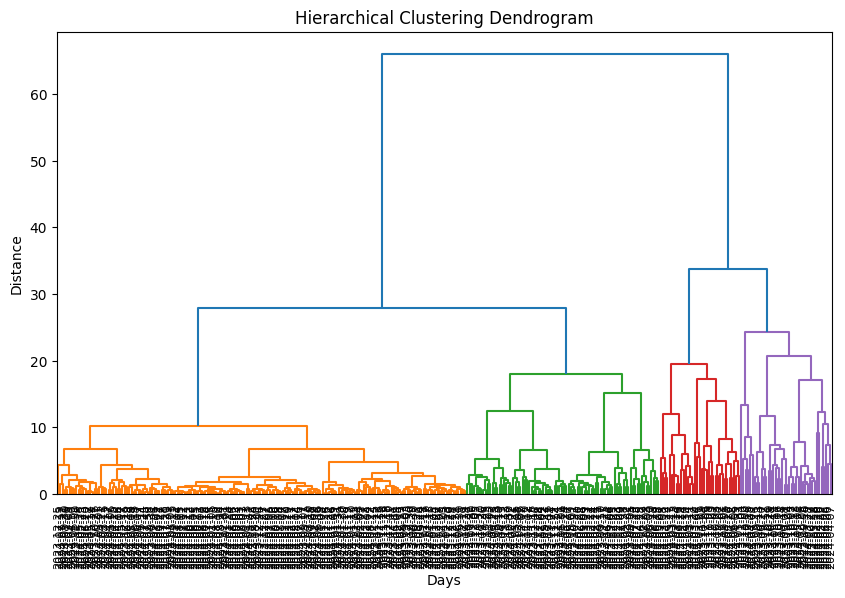

In [ ]:
import pandas as pd

# Load the data from the uploaded Excel file
file_path = 'Days_without_high_volatile_days(92.08 per cent).xlsx'

# Load all sheets to inspect the structure of the file
xls = pd.ExcelFile(file_path)

# Checking the names of the sheets to understand the file's structure
sheet_names = xls.sheet_names

# Load the first sheet to inspect the data
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Convert the 'Datetime' column to pandas datetime type for easier manipulation
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Define the time segments
time_segments = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '00:00')
]

# Initialize a list to store the features for each day
features = []

# Group the data by day
data['Day'] = data['Datetime'].dt.date
grouped_by_day = data.groupby('Day')

# Function to calculate features for each time segment
def calculate_features_for_day(day_data, segments):
    day_features = []
    for start_time, end_time in segments:
        segment_data = day_data.between_time(start_time, end_time)['USEP (c/kWh)']
        if not segment_data.empty:
            max_value = segment_data.max()
            std_dev = segment_data.std()
            is_max_over_20 = 1 if max_value > 24.14 else 0 #17.78+6.36=24,14
        else:
            max_value = std_dev = is_max_over_20 = 0
        day_features.extend([max_value, std_dev, is_max_over_20])
    return day_features

# Iterate over each day, calculate the required features, and append to the list
for day, day_data in grouped_by_day:
    # Convert to time-indexed dataframe for between_time usage
    day_data = day_data.set_index('Datetime')
    day_features = calculate_features_for_day(day_data, time_segments)
    features.append([day] + day_features)

# Create a dataframe for the calculated features
columns = ['Day'] + [f'Segment{i+1}_{metric}' for i in range(6) for metric in ['Max', 'Std', 'MaxOver20']]
features_df = pd.DataFrame(features, columns=columns)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Extracting only the feature columns for clustering
feature_columns = features_df.columns[1:]  # Exclude the 'Day' column
X = features_df[feature_columns]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform hierarchical clustering using the Ward method
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Days")
plt.ylabel("Distance")
dendrogram(Z, labels=features_df['Day'].values, leaf_rotation=90, leaf_font_size=8, color_threshold=26)
plt.show()


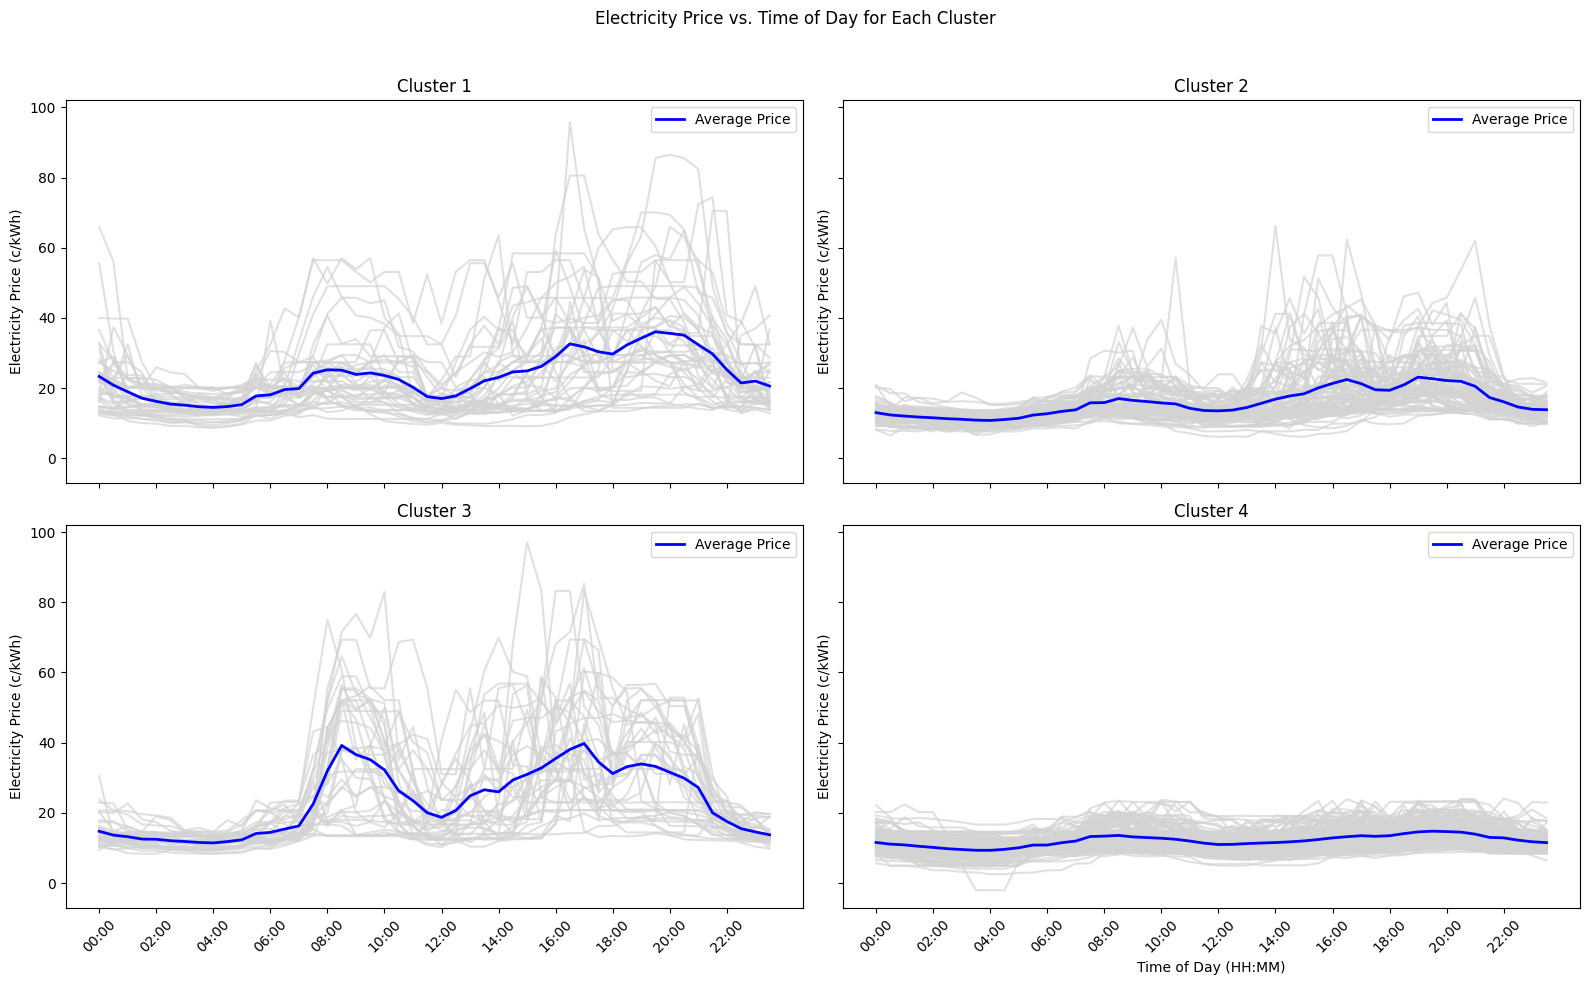

In [ ]:
# Perform agglomerative clustering with 4 clusters
agg_cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clusters = agg_cluster.fit_predict(X_scaled)

# Add the cluster labels to the original features dataframe
features_df['Cluster'] = clusters

# Convert time-of-day values to string format for proper plotting (again for safety)
data['TimeOfDay'] = data['Datetime'].dt.strftime('%H:%M')

# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each cluster and plot the data for each cluster
for cluster_num in range(4):
    # Get the days that belong to the current cluster
    cluster_days = features_df[features_df['Cluster'] == cluster_num]['Day']

    # Filter the original data for these days
    cluster_data = data[data['Day'].isin(cluster_days)]

    # Group by TimeOfDay to get the average electricity price for the cluster
    cluster_avg = cluster_data.groupby('TimeOfDay')['USEP (c/kWh)'].mean()

    # Plot individual days within the cluster
    for day in cluster_days:
        day_data = data[data['Day'] == day]
        axes[cluster_num].plot(day_data['TimeOfDay'], day_data['USEP (c/kWh)'], color='lightgray', alpha=0.7)

    # Plot the average price for the cluster
    axes[cluster_num].plot(cluster_avg.index, cluster_avg.values, color='blue', linewidth=2, label='Average Price')

    # Set title and labels
    axes[cluster_num].set_title(f'Cluster {cluster_num + 1}')
    axes[cluster_num].set_ylabel('Electricity Price (c/kWh)')
    axes[cluster_num].set_xticks(cluster_avg.index[::4])  # Reduce the number of x-ticks for clarity
    axes[cluster_num].set_xticklabels(cluster_avg.index[::4], rotation=45)
    axes[cluster_num].legend()

# Set common x-axis label
plt.xlabel('Time of Day (HH:MM)')
plt.suptitle('Electricity Price vs. Time of Day for Each Cluster')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [ ]:
# Calculate the proportion of days in each cluster
cluster_proportions = features_df['Cluster'].value_counts(normalize=True).sort_index()

# Convert proportions to percentages
cluster_proportions = (cluster_proportions * 100).round(2)

# Create a table to display the proportions
proportion_table = pd.DataFrame({
    'Cluster': cluster_proportions.index + 1,  # To match cluster numbering (1-based)
    'Proportion (%)': cluster_proportions.values
})


# Show the table
proportion_table


,Cluster,Proportion (%)
0,1,11.87
1,2,24.93
2,3,10.39
3,4,52.82


In [ ]:
import pandas as pd

# Load the original data
file_path = 'Days_without_high_volatile_days(92.08 per cent).xlsx'
original_data = pd.read_excel(file_path, sheet_name='Sheet1')
original_data['Datetime'] = pd.to_datetime(original_data['Datetime'])  # Convert to datetime

# Create the 'Day' column in the original data
original_data['Day'] = original_data['Datetime'].dt.date

# Merge with features_df to get cluster assignments for each row
merged_data = pd.merge(original_data, features_df[['Day', 'Cluster']], on='Day', how='left')

# Filter data for cluster 3
cluster_3_data = merged_data[merged_data['Cluster'] == 2]

# Filter data for clusters 1, 2, and 4
other_clusters_data = merged_data[merged_data['Cluster'].isin([0, 1, 3])]

# Save the filtered data to separate Excel files
cluster_3_data[['Datetime', 'USEP (c/kWh)']].to_excel("cluster_3_days.xlsx", index=False)
other_clusters_data[['Datetime', 'USEP (c/kWh)']].to_excel("other_clusters_days.xlsx", index=False)

<ipython-input-6-a1324593dbc8>:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('Date').apply(calculate_features).reset_index()


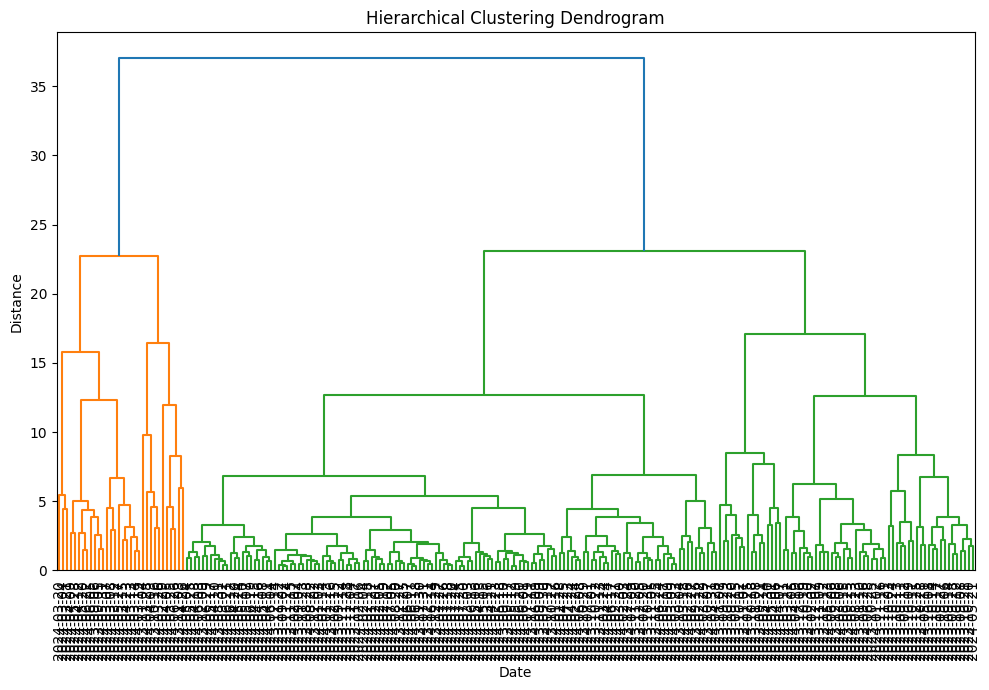

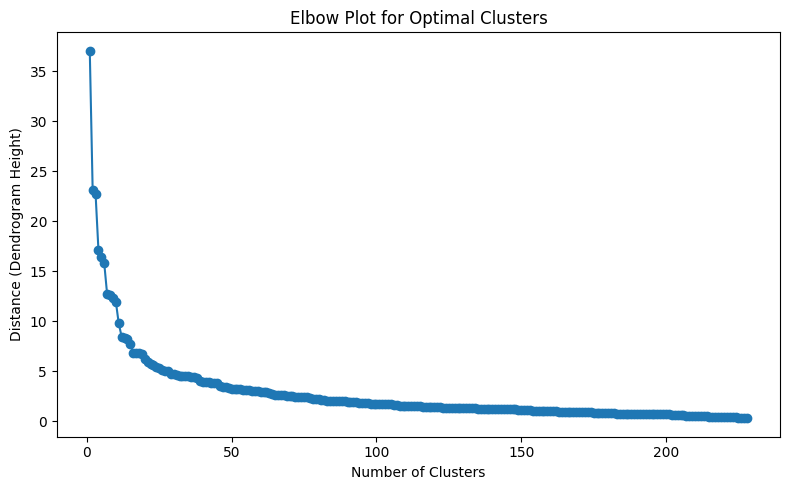

In [ ]:
import pandas as pd

# Load the provided Excel file to inspect its contents
file_path = 'Medium_volatile_days(62.59 per cent)_Q3.xlsx'
xls = pd.ExcelFile(file_path)

# Check the sheet names to understand the structure of the file
xls.sheet_names

# Load the data from the first sheet to examine its structure
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Step 1: Convert the Datetime column to datetime objects and extract the time part
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Time'] = df['Datetime'].dt.time
df['Date'] = df['Datetime'].dt.date

# Define the time periods of interest
time_periods = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '00:00')
]

# Convert the time periods to time objects for comparison
time_periods = [(pd.to_datetime(start).time(), pd.to_datetime(end).time()) for start, end in time_periods]

# Step 2: Function to calculate max and std for each time segment
def calculate_features(group):
    features = {}
    for i, (start, end) in enumerate(time_periods):
        if start < end:
            # Filter rows within the time period (for segments within the same day)
            period_data = group[(group['Time'] >= start) & (group['Time'] < end)]
        else:
            # Handle overnight periods (crossing midnight)
            period_data = group[(group['Time'] >= start) | (group['Time'] < end)]

        # Calculate max and std for this period
        features[f'max_period_{i+1}'] = period_data['USEP (c/kWh)'].max()
        features[f'std_period_{i+1}'] = period_data['USEP (c/kWh)'].std()

    return pd.Series(features)

# Step 3: Group by Date and calculate the features
grouped = df.groupby('Date').apply(calculate_features).reset_index()

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Step 1: Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(grouped.iloc[:, 1:])  # Exclude the 'Date' column

# Step 2: Perform hierarchical clustering using 'ward' linkage method
linkage_matrix = linkage(scaled_data, method='ward')

# Step 3: Plot the dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(linkage_matrix, labels=grouped['Date'].astype(str).values, leaf_rotation=90, leaf_font_size=10)
plt.xlabel('Date')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Step 1: Calculate the distances (height in the dendrogram) at which clusters are merged
distances = linkage_matrix[:, 2]

# Step 2: Plot an "elbow" plot to visualize where the largest gap occurs (optimal number of clusters)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(distances) + 1), distances[::-1], marker='o')
plt.title('Elbow Plot for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distance (Dendrogram Height)')
plt.tight_layout()
plt.show()


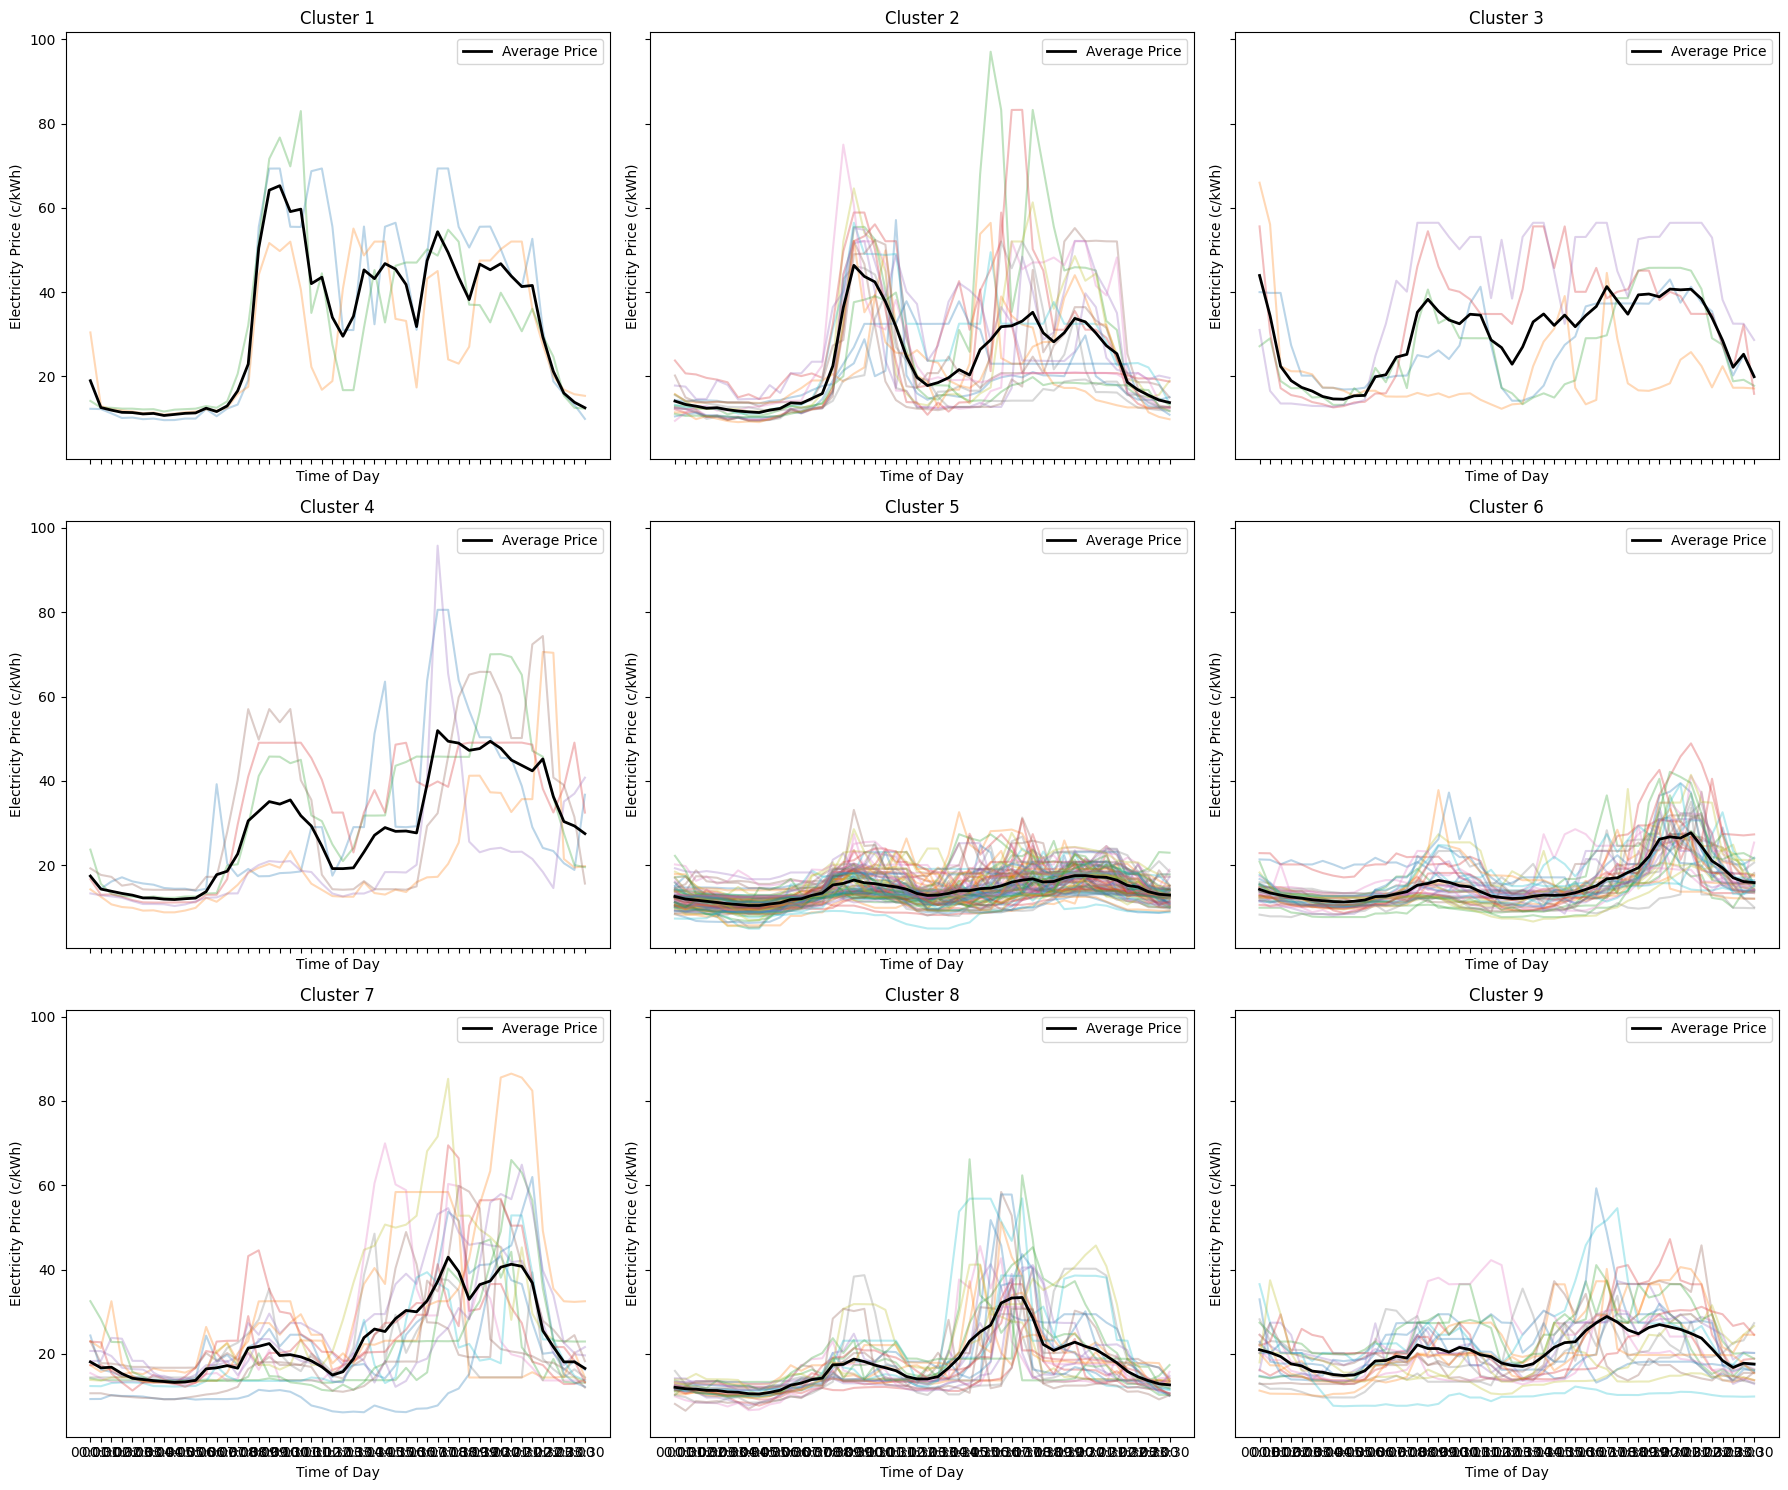

In [ ]:
from scipy.cluster.hierarchy import fcluster
df['Time'] = df['Datetime'].dt.strftime('%H:%M')

# Step 1: Perform clustering with 9 clusters
num_clusters = 9
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add the cluster labels to the original grouped data
grouped['Cluster'] = cluster_labels

# Step 2: Prepare a new plot with 9 clusters
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharex=True, sharey=True)
axes = axes.flatten()

# Iterate over each cluster
for cluster_num in range(1, num_clusters + 1):
    cluster_days = grouped[grouped['Cluster'] == cluster_num]['Date']
    cluster_data = df[df['Date'].isin(cluster_days)]

    # Plot each day's electricity price in the cluster
    for day in cluster_days:
        day_data = cluster_data[cluster_data['Date'] == day]
        axes[cluster_num - 1].plot(day_data['Time'], day_data['USEP (c/kWh)'], alpha=0.3)

    # Calculate the average price for this cluster and plot it
    avg_price = cluster_data.groupby('Time')['USEP (c/kWh)'].mean()
    axes[cluster_num - 1].plot(avg_price.index, avg_price.values, color='black', label='Average Price', linewidth=2)

    axes[cluster_num - 1].set_title(f'Cluster {cluster_num}')
    axes[cluster_num - 1].set_xlabel('Time of Day')
    axes[cluster_num - 1].set_ylabel('Electricity Price (c/kWh)')
    axes[cluster_num - 1].legend()

plt.tight_layout()
plt.show()


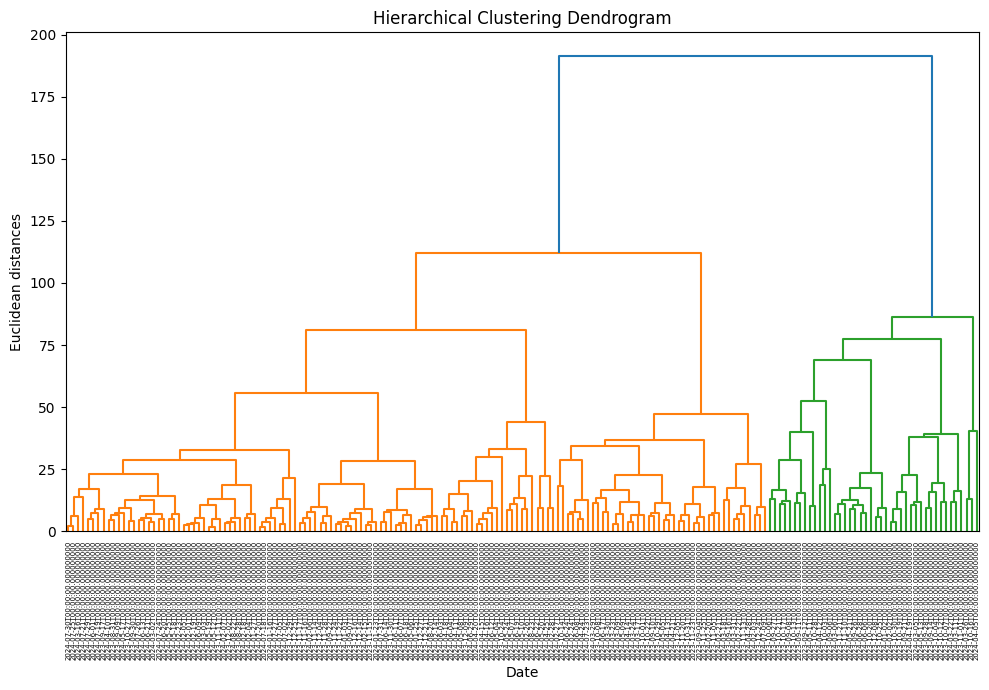

In [ ]:
import pandas as pd

# Load the data from the uploaded file
file_path = 'Medium_volatile_days_max_under_50 (49.45 per cent)_Q3.xlsx'

xls = pd.ExcelFile(file_path)

# Checking sheet names to understand the structure of the file
xls.sheet_names

# Load the data from the first sheet
data = pd.read_excel(xls, sheet_name='Sheet1')

# Convert Datetime column to datetime object
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Define the time intervals for feature extraction
time_intervals = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '23:30')
]

# Extract the hour and minute from the Datetime column to match against intervals
data['Time'] = data['Datetime'].dt.time

# Prepare a list to store the feature extraction results
features_list = []

# Function to filter data by a specific time range within a day
def filter_by_time(data, start_time, end_time):
    if start_time < end_time:
        return data[(data['Time'] >= pd.to_datetime(start_time).time()) &
                    (data['Time'] < pd.to_datetime(end_time).time())]
    else:
        # Handle the time range that spans across midnight
        return data[(data['Time'] >= pd.to_datetime(start_time).time()) |
                    (data['Time'] < pd.to_datetime(end_time).time())]

# Extract features for each day
for day, day_data in data.groupby('Date'):
    day_features = {}
    day_features['Date'] = day

    for start_time, end_time in time_intervals:
        segment_data = filter_by_time(day_data, start_time, end_time)

        # Extract maximum and standard deviation for the segment
        max_value = segment_data['USEP (c/kWh)'].max()
        std_value = segment_data['USEP (c/kWh)'].std()

        # Store these features
        feature_prefix = f'{start_time}-{end_time}'
        day_features[f'{feature_prefix}_max'] = max_value
        day_features[f'{feature_prefix}_std'] = std_value

    features_list.append(day_features)

# Convert the list of features into a DataFrame
features_df = pd.DataFrame(features_list)

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linked = linkage(features_df.drop(columns=['Date']), method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=features_df['Date'].values, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Date')
plt.ylabel('Euclidean distances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


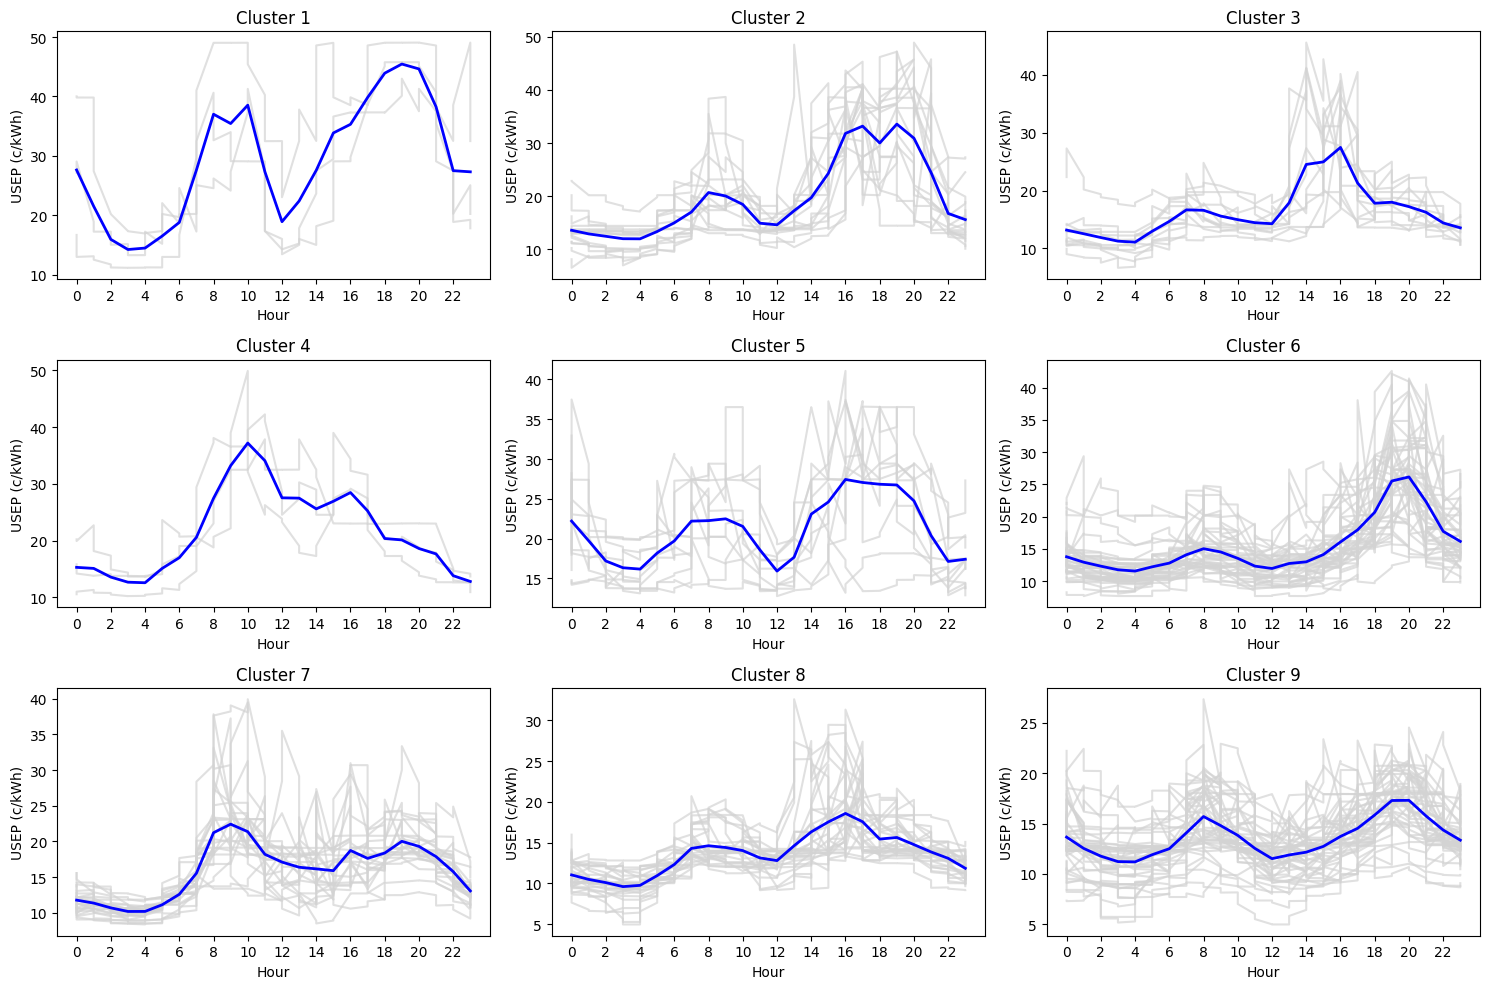

In [ ]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

# Set the number of clusters
n_clusters = 9

# Perform hierarchical clustering and assign cluster labels
clusters = fcluster(linked, n_clusters, criterion='maxclust')

# Add cluster labels to the features_df
features_df['Cluster'] = clusters

# Prepare data for plotting: average price per hour of each cluster
data['Hour'] = data['Datetime'].dt.hour

# Create a new DataFrame to store hourly average USEP per cluster
hourly_avg_per_cluster = pd.DataFrame()

plt.figure(figsize=(15, 10))  # Adjust the figure size for a 4x3 grid

for cluster_num in range(1, n_clusters + 1):
    plt.subplot(3, 3, cluster_num)  # Create a 4x3 grid of subplots

    cluster_dates = features_df[features_df['Cluster'] == cluster_num]['Date']
    cluster_data = data[data['Date'].isin(cluster_dates)]

    # Plot individual days
    for day in cluster_dates:
        day_data = cluster_data[cluster_data['Date'] == day]
        plt.plot(day_data['Hour'], day_data['USEP (c/kWh)'],color='lightgray', alpha=0.7)

    # Plot the average price for the cluster
    hourly_avg = cluster_data.groupby('Hour')['USEP (c/kWh)'].mean()
    plt.plot(hourly_avg.index, hourly_avg, color='blue', linewidth=2, label=f'Cluster {cluster_num} Avg')


    plt.title(f'Cluster {cluster_num}')
    plt.xlabel('Hour')
    plt.ylabel('USEP (c/kWh)')
    #plt.grid(True)

    plt.xticks(np.arange(0, 24, 2))

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the proportion of days in each cluster
cluster_counts = features_df['Cluster'].value_counts()
total_days = features_df['Cluster'].count()

# Create a DataFrame for the proportion of days in each cluster
cluster_proportions = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Number of Days': cluster_counts.values,
    'Proportion': (cluster_counts / total_days) * 100
})

cluster_proportions

,Cluster,Number of Days,Proportion
Cluster,,,
9,9,46,25.414365
6,6,42,23.204420
8,8,28,15.469613
7,7,23,12.707182
2,2,15,8.287293
3,3,11,6.077348
5,5,10,5.524862
4,4,3,1.657459
1,1,3,1.657459


In [ ]:
# Add cluster labels to the DataFrame
features_df['Cluster'] = clusters

# Extract days with surge in the morning with low magnitude
# Filter data for clusters 4
cluster_4_dates = features_df[features_df['Cluster'].isin([4])]['Date']
cluster_4_data = data[data['Date'].isin(cluster_4_dates)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Morning_Low_Magnitude(3d).xlsx'
cluster_4_data.to_excel(output_file_path, index=False)

output_file_path

# Extract days with surge in the afternoon with low magnitude
# Filter data for clusters 3 and 8
cluster_3_8_dates = features_df[features_df['Cluster'].isin([3, 8])]['Date']
cluster_3_8_data = data[data['Date'].isin(cluster_3_8_dates)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Afternoon_Low_Magnitude(39d).xlsx'
cluster_3_8_data.to_excel(output_file_path, index=False)

output_file_path

# Extract days with surge in the evening with low magnitude
# Filter data for clusters 6
cluster_6_dates = features_df[features_df['Cluster'].isin([6])]['Date']
cluster_6_data = data[data['Date'].isin(cluster_6_dates)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Evening_Low_Magnitude(42d).xlsx'
cluster_6_data.to_excel(output_file_path, index=False)

output_file_path

# Extract days with surge in the morning and afternoon with low magnitude
# Filter data for clusters 1,2,5,9
cluster_1259_dates = features_df[features_df['Cluster'].isin([1,2,5,9])]['Date']
cluster_1259_data = data[data['Date'].isin(cluster_1259_dates)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Morning_Afternoon_Low_Magnitude(74d).xlsx'
cluster_1259_data.to_excel(output_file_path, index=False)

output_file_path

# All day volatile with low magnitude
# Filter data for clusters 7
cluster_7_dates = features_df[features_df['Cluster'].isin([7])]['Date']
cluster_7_data = data[data['Date'].isin(cluster_7_dates)]

# Save the filtered data to an Excel file
output_file_path = 'All_day_volatile_Low_Magnitude(23d).xlsx'
cluster_7_data.to_excel(output_file_path, index=False)

output_file_path

'All_day_volatile_Low_Magnitude(23d).xlsx'

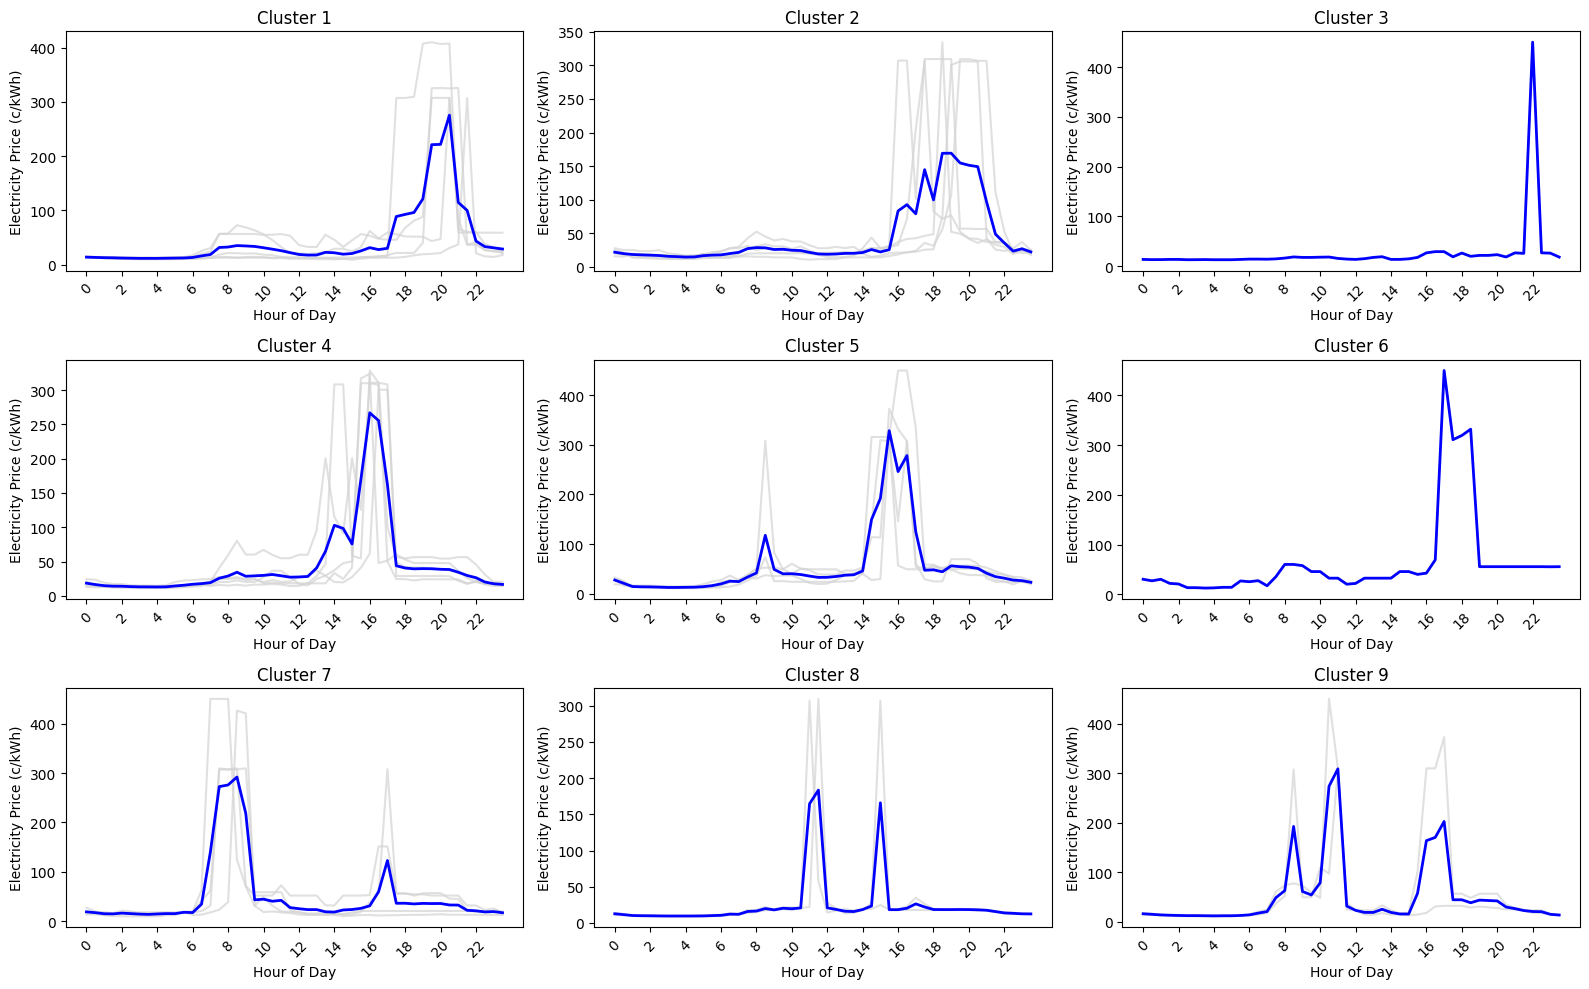

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Load the data
#file_path = 'Medium_volatile_days_max_above_50 (13.12 per cent)_Q3.xlsx'
file_path = 'High_Volatile_days(7.92 per cent).xlsx'
data = pd.read_excel(file_path)

# Convert Datetime column to datetime type
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Create a new column for the date to aggregate by days
data['Date'] = data['Datetime'].dt.date

# Define time segments
time_segments = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '23:30')
]

# Function to extract max and standard deviation for a time segment
def extract_features(df, start_time, end_time):
    mask = (df['Datetime'].dt.time >= pd.to_datetime(start_time).time()) & (df['Datetime'].dt.time < pd.to_datetime(end_time).time())
    segment_data = df[mask]
    return segment_data['USEP (c/kWh)'].max(), segment_data['USEP (c/kWh)'].std()

# Extract features for each day
features = []
for date, group in data.groupby('Date'):
    day_features = [date]
    for start_time, end_time in time_segments:
        max_price, std_price = extract_features(group, start_time, end_time)
        day_features.extend([max_price, std_price])
    features.append(day_features)

# Create a DataFrame for the features
columns = ['Date'] + [f'max_{i+1}' for i in range(6)] + [f'std_{i+1}' for i in range(6)]
features_df = pd.DataFrame(features, columns=columns)

# Drop the 'Date' column and fill NaN values in the numeric columns
features_df_clean = features_df.drop(columns=['Date']).fillna(features_df.drop(columns=['Date']).mean())

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df_clean)

# Handle any remaining non-finite values (like NaN or inf)
scaled_features_clean = np.where(np.isfinite(scaled_features), scaled_features, 0)

# Hierarchical clustering
Z = linkage(scaled_features_clean, method='ward')
num_clusters = 9
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

# Add cluster labels to the original data
data['Cluster'] = None
for date, label in zip(features_df['Date'], cluster_labels):
    data.loc[data['Datetime'].dt.date == date, 'Cluster'] = label

# Convert time to hour fractions for plotting
data['Hour'] = data['Datetime'].dt.hour + data['Datetime'].dt.minute / 60

# Plot electricity price vs 24-hour day for each cluster
plt.figure(figsize=(16, 10))
for cluster_num in range(1, num_clusters + 1):
    cluster_data = data[data['Cluster'] == cluster_num]
    plt.subplot(3, 3, cluster_num)

    # Plot daily electricity prices
    for date, group in cluster_data.groupby(cluster_data['Datetime'].dt.date):
        plt.plot(group['Hour'], group['USEP (c/kWh)'], color='lightgray', alpha=0.7)

    # Plot average electricity price for the cluster
    avg_price = cluster_data.groupby('Hour')['USEP (c/kWh)'].mean()
    plt.plot(avg_price.index, avg_price.values, label='Average', color='blue', linewidth=2)

    plt.title(f'Cluster {cluster_num}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Electricity Price (c/kWh)')
    plt.xticks(rotation=45)
    #plt.legend()

    plt.xticks(np.arange(0, 24, 2))

plt.tight_layout()
plt.show()


In [ ]:
# Recalculate the proportion of days in each cluster
cluster_proportions = data.groupby('Cluster')['Date'].nunique() / data['Date'].nunique() * 100

# Create a DataFrame to display the proportions
cluster_proportions_df = pd.DataFrame(cluster_proportions).reset_index()
cluster_proportions_df.columns = ['Cluster', 'Proportion of Days (%)']

cluster_proportions_df


,Cluster,Proportion of Days (%)
0,1,17.241379
1,2,17.241379
2,3,3.448276
3,4,17.241379
4,5,13.793103
5,6,3.448276
6,7,13.793103
7,8,6.896552
8,9,6.896552


In [ ]:
# Extract days with surges in the evening with high magnitude

#Add cluster labels to features_df for reference
features_df['Cluster'] = cluster_labels

# Filter days that are in clusters 1, 2, and 3
selected_clusters = [1, 2, 3]
days_in_selected_clusters = features_df[features_df['Cluster'].isin(selected_clusters)]

from IPython.display import display

display(days_in_selected_clusters)


# Filter the original data for dates in clusters 1, 2, and 3
dates_in_clusters = days_in_selected_clusters['Date']
filtered_data = data[data['Datetime'].dt.date.isin(dates_in_clusters)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Evening_High_Magnitude(11d).xlsx'
filtered_data.to_excel(output_file_path, index=False)


,Date,max_1,max_2,max_3,max_4,max_5,max_6,std_1,std_2,std_3,std_4,std_5,std_6,Cluster
0,2023-09-13,21.805,1.955380,31.026,3.016703,19.064,2.496887,205.197,59.943549,306.680,86.266474,29.410,5.799849,2
3,2023-10-05,23.084,2.152785,52.053,7.510553,31.710,2.079023,42.297,7.129832,334.738,97.084488,36.578,5.256854,2
5,2023-10-15,27.291,3.887845,15.706,1.328250,11.260,0.505538,22.080,3.521666,306.125,141.129662,25.141,0.982081,2
6,2023-11-02,14.023,0.382493,18.377,1.850085,15.378,0.873305,28.995,6.490619,26.577,3.215322,450.000,244.641354,3
11,2024-04-02,17.193,1.261376,56.460,12.455046,56.287,11.990812,56.254,8.713951,307.455,120.242847,60.166,14.676599,1
15,2024-04-27,14.035,0.632978,21.454,3.318617,14.209,0.840115,17.478,1.570230,325.665,156.698893,40.712,8.667777,1
16,2024-04-29,24.487,4.033662,33.268,6.331248,23.794,2.726577,307.335,122.415640,309.597,135.752004,34.755,6.754044,2
20,2024-05-22,19.715,2.669016,20.745,2.596360,20.766,0.460983,23.453,2.681271,309.459,129.565196,52.273,18.178212,2
21,2024-05-26,13.872,0.994579,14.164,1.076063,12.514,0.976199,15.844,2.441973,410.172,142.798085,58.887,0.000000,1
22,2024-05-29,14.674,0.757091,72.601,18.623577,32.390,5.996358,62.106,15.831869,307.210,85.842333,36.462,6.496721,1


In [ ]:
# Extract days with surges in the afternoon with high magnitude

#Add cluster labels to features_df for reference
features_df['Cluster'] = cluster_labels

# Filter days that are in clusters 4,6
selected_clusters = [4,6]
days_in_selected_clusters = features_df[features_df['Cluster'].isin(selected_clusters)]

from IPython.display import display

display(days_in_selected_clusters)


# Filter the original data for dates in clusters 4,6
dates_in_clusters = days_in_selected_clusters['Date']
filtered_data = data[data['Datetime'].dt.date.isin(dates_in_clusters)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Afternoon_High_Magnitude(6d).xlsx'
filtered_data.to_excel(output_file_path, index=False)

output_file_path

,Date,max_1,max_2,max_3,max_4,max_5,max_6,std_1,std_2,std_3,std_4,std_5,std_6,Cluster
1,2023-09-18,20.229,1.771981,36.567,6.318197,36.543,9.836341,323.605,123.416449,60.483,9.808543,20.363,1.675470,4
4,2023-10-10,24.465,3.605966,27.431,2.277996,29.437,4.603803,300.506,118.311803,48.870,5.340337,24.558,4.087580,4
7,2023-11-06,15.230,0.649764,17.344,0.923234,18.349,1.847740,328.387,140.336783,28.998,4.194183,21.428,3.550017,4
9,2024-03-27,30.319,7.107604,60.143,15.356709,32.513,6.582237,450.000,136.265693,332.110,132.713456,55.602,0.122976,6
10,2024-04-01,19.957,2.330256,80.242,21.865134,59.945,2.931958,310.704,88.751759,56.460,1.022216,45.749,12.820930,4
18,2024-05-03,16.955,1.428813,25.773,3.129507,18.340,0.028077,309.882,139.411635,24.524,1.956595,20.299,1.074241,4


'Surge_Afternoon_High_Magnitude(6d).xlsx'

In [ ]:
# Extract days with surges in the morning and in the afternoon with high magnitude

#Add cluster labels to features_df for reference
features_df['Cluster'] = cluster_labels

# Filter days that are in clusters 5,7,8,9
selected_clusters = [5,7,8,9]
days_in_selected_clusters = features_df[features_df['Cluster'].isin(selected_clusters)]

from IPython.display import display

display(days_in_selected_clusters)


# Filter the original data for dates in clusters 5,7,8,9
dates_in_clusters = days_in_selected_clusters['Date']
filtered_data = data[data['Datetime'].dt.date.isin(dates_in_clusters)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Morning_Afternoon_High_Magnitude(12d).xlsx'
filtered_data.to_excel(output_file_path, index=False)

output_file_path

,Date,max_1,max_2,max_3,max_4,max_5,max_6,std_1,std_2,std_3,std_4,std_5,std_6,Cluster
2,2023-09-19,27.367,3.965050,37.252,3.696799,27.320,3.608281,450.000,191.292997,58.401,10.606654,25.382,3.591858,5
8,2024-03-01,18.204,2.916599,309.430,131.740674,72.828,10.387001,151.691,47.048001,55.602,7.342935,32.038,4.621982,7
12,2024-04-04,29.294,4.505783,52.314,11.086795,47.251,4.437718,372.743,136.769393,56.460,3.679784,38.457,3.125817,5
13,2024-04-08,32.508,6.656755,308.092,88.728638,49.074,0.011358,316.025,134.556740,56.460,4.348905,37.865,7.505892,5
14,2024-04-22,14.767,1.242166,307.315,90.568587,307.369,139.799737,372.684,150.745899,56.460,13.859637,23.048,4.384981,9
17,2024-05-02,29.007,5.552325,72.901,17.334870,23.819,0.010739,309.654,125.487267,69.582,21.692487,23.858,0.119266,5
19,2024-05-16,11.474,0.466741,22.094,3.580232,309.563,143.191867,307.209,96.461546,17.838,0.468474,12.881,0.258274,8
23,2024-05-30,27.335,3.264235,309.597,132.829643,58.761,20.557490,20.830,3.161715,20.831,0.010014,19.689,0.006658,7
24,2024-06-10,13.891,1.501744,20.828,3.349769,307.243,140.178542,34.842,5.454034,26.322,3.001317,14.876,1.095862,8
26,2024-06-25,19.923,2.023675,450.000,196.060070,19.940,1.877525,307.646,95.724367,57.042,11.238800,20.018,0.068739,7


'Surge_Morning_Afternoon_High_Magnitude(12d).xlsx'

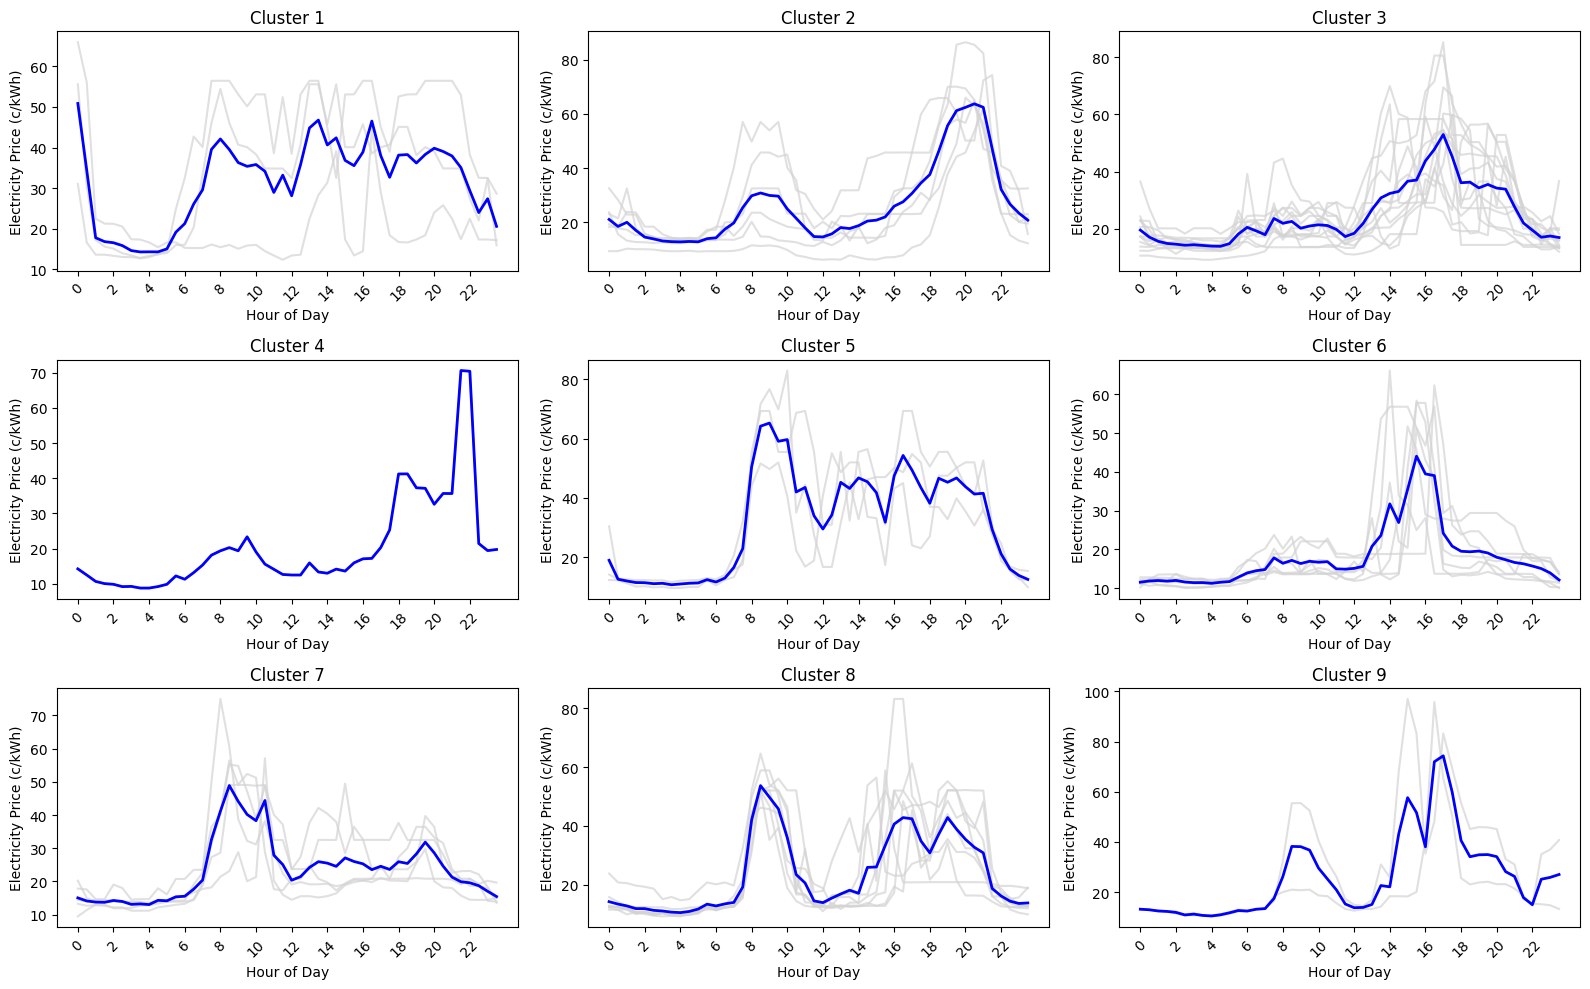

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Load the data
file_path = 'Medium_volatile_days_max_above_50 (13.12 per cent)_Q3.xlsx'
data = pd.read_excel(file_path)

# Convert Datetime column to datetime type
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Create a new column for the date to aggregate by days
data['Date'] = data['Datetime'].dt.date

# Define time segments
time_segments = [
    ('00:00', '06:30'),
    ('06:30', '11:00'),
    ('11:00', '13:00'),
    ('13:00', '17:30'),
    ('17:30', '22:00'),
    ('22:00', '23:30')
]

# Function to extract max and standard deviation for a time segment
def extract_features(df, start_time, end_time):
    mask = (df['Datetime'].dt.time >= pd.to_datetime(start_time).time()) & (df['Datetime'].dt.time < pd.to_datetime(end_time).time())
    segment_data = df[mask]
    return segment_data['USEP (c/kWh)'].max(), segment_data['USEP (c/kWh)'].std()

# Extract features for each day
features = []
for date, group in data.groupby('Date'):
    day_features = [date]
    for start_time, end_time in time_segments:
        max_price, std_price = extract_features(group, start_time, end_time)
        day_features.extend([max_price, std_price])
    features.append(day_features)

# Create a DataFrame for the features
columns = ['Date'] + [f'max_{i+1}' for i in range(6)] + [f'std_{i+1}' for i in range(6)]
features_df = pd.DataFrame(features, columns=columns)

# Drop the 'Date' column and fill NaN values in the numeric columns
features_df_clean = features_df.drop(columns=['Date']).fillna(features_df.drop(columns=['Date']).mean())

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df_clean)

# Handle any remaining non-finite values (like NaN or inf)
scaled_features_clean = np.where(np.isfinite(scaled_features), scaled_features, 0)

# Hierarchical clustering
Z = linkage(scaled_features_clean, method='ward')
num_clusters = 9
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

# Add cluster labels to the original data
data['Cluster'] = None
for date, label in zip(features_df['Date'], cluster_labels):
    data.loc[data['Datetime'].dt.date == date, 'Cluster'] = label

# Convert time to hour fractions for plotting
data['Hour'] = data['Datetime'].dt.hour + data['Datetime'].dt.minute / 60

# Plot electricity price vs 24-hour day for each cluster
plt.figure(figsize=(16, 10))
for cluster_num in range(1, num_clusters + 1):
    cluster_data = data[data['Cluster'] == cluster_num]
    plt.subplot(3, 3, cluster_num)

    # Plot daily electricity prices
    for date, group in cluster_data.groupby(cluster_data['Datetime'].dt.date):
        plt.plot(group['Hour'], group['USEP (c/kWh)'], color='lightgray', alpha=0.7)

    # Plot average electricity price for the cluster
    avg_price = cluster_data.groupby('Hour')['USEP (c/kWh)'].mean()
    plt.plot(avg_price.index, avg_price.values, label='Average', color='blue', linewidth=2)

    plt.title(f'Cluster {cluster_num}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Electricity Price (c/kWh)')
    plt.xticks(rotation=45)
    #plt.legend()

    plt.xticks(np.arange(0, 24, 2))

plt.tight_layout()
plt.show()


In [ ]:
# Recalculate the proportion of days in each cluster
cluster_proportions = data.groupby('Cluster')['Date'].nunique() / data['Date'].nunique() * 100

# Create a DataFrame to display the proportions
cluster_proportions_df = pd.DataFrame(cluster_proportions).reset_index()
cluster_proportions_df.columns = ['Cluster', 'Proportion of Days (%)']

cluster_proportions_df

,Cluster,Proportion of Days (%)
0,1,6.250000
1,2,12.500000
2,3,27.083333
3,4,2.083333
4,5,6.250000
5,6,14.583333
6,7,10.416667
7,8,16.666667
8,9,4.166667


In [ ]:
# Extract days with surges in the morning with medium magnitude

#Add cluster labels to features_df for reference
features_df['Cluster'] = cluster_labels

# Filter days that are in clusters 7
selected_clusters = [7]
days_in_selected_clusters = features_df[features_df['Cluster'].isin(selected_clusters)]

from IPython.display import display

display(days_in_selected_clusters)


# Filter the original data for dates in clusters 7
dates_in_clusters = days_in_selected_clusters['Date']
filtered_data = data[data['Datetime'].dt.date.isin(dates_in_clusters)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Morning_Medium_Magnitude(5d).xlsx'
filtered_data.to_excel(output_file_path, index=False)

output_file_path

,Date,max_1,max_2,max_3,max_4,max_5,max_6,std_1,std_2,std_3,std_4,std_5,std_6,Cluster
0,2023-09-05,15.517,0.543519,57.110,12.583571,20.278,2.549801,21.050,2.343632,29.735,4.252895,14.506,0.029160,7
35,2024-04-09,13.281,0.741658,56.460,14.721602,32.506,5.054431,49.476,6.657602,37.659,4.921385,23.187,2.542773,7
44,2024-05-28,20.759,2.308589,55.229,11.877939,40.121,7.822549,42.152,6.920481,39.720,6.689782,20.827,0.787000,7
45,2024-05-31,20.232,1.803453,52.395,14.948543,20.808,1.911447,24.732,2.382674,36.445,6.140217,18.673,0.385763,7
46,2024-06-05,14.276,1.305444,74.988,18.117814,28.942,4.472283,20.832,0.850885,21.015,0.570202,20.830,3.454792,7


'Surge_Morning_Medium_Magnitude(5d).xlsx'

In [ ]:
# Extract days with surges in the afternoon with medium magnitude

#Add cluster labels to features_df for reference
features_df['Cluster'] = cluster_labels

# Filter days that are in clusters 3,6
selected_clusters = [3,6]
days_in_selected_clusters = features_df[features_df['Cluster'].isin(selected_clusters)]

from IPython.display import display

display(days_in_selected_clusters)

# Filter the original data for dates in clusters 3,6
dates_in_clusters = days_in_selected_clusters['Date']
filtered_data = data[data['Datetime'].dt.date.isin(dates_in_clusters)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Afternoon_Medium_Magnitude(20d).xlsx'
filtered_data.to_excel(output_file_path, index=False)

output_file_path

,Date,max_1,max_2,max_3,max_4,max_5,max_6,std_1,std_2,std_3,std_4,std_5,std_6,Cluster
1,2023-09-15,24.367,3.793647,25.929,2.651987,17.292,1.310076,53.708,13.200429,51.616,9.136978,20.370,2.068077,3
2,2023-09-20,26.400,3.069067,29.415,3.289941,27.310,5.474276,58.401,10.333187,51.332,12.262124,20.404,3.410143,3
3,2023-09-25,13.595,0.478600,17.323,1.425309,15.488,0.668042,51.750,13.162887,29.420,3.060111,17.779,0.499676,6
4,2023-09-29,20.676,2.440364,28.969,3.702353,18.148,1.386927,69.479,15.136714,66.418,14.387988,14.641,1.023067,3
5,2023-10-02,20.699,2.339861,29.560,3.818814,24.565,2.961870,54.575,10.073980,48.878,6.549980,20.223,1.588607,3
6,2023-10-09,36.548,4.912929,27.446,2.371114,24.562,2.911140,54.569,10.958183,37.470,4.097783,20.232,1.434934,3
7,2023-10-11,24.522,3.945909,27.461,2.780649,29.432,4.005042,59.290,12.819279,31.911,1.979481,17.375,0.716531,3
8,2023-10-18,22.966,1.830883,20.245,1.242014,17.356,1.659093,48.909,9.830750,56.448,14.511216,25.729,1.541383,3
9,2023-10-23,15.474,0.978826,20.942,2.975390,25.166,4.956887,69.948,15.494144,59.794,14.198947,13.707,0.003464,3
10,2023-11-03,39.213,6.713043,29.037,3.703728,29.033,5.609627,80.578,22.320096,63.871,12.650367,23.359,2.269311,3


'Surge_Afternoon_Medium_Magnitude(20d).xlsx'

In [ ]:
# Extract days with surges in the evening with medium magnitude

#Add cluster labels to features_df for reference
features_df['Cluster'] = cluster_labels

# Filter days that are in clusters 4
selected_clusters = [4]
days_in_selected_clusters = features_df[features_df['Cluster'].isin(selected_clusters)]

from IPython.display import display

display(days_in_selected_clusters)

# Filter the original data for dates in clusters 4
dates_in_clusters = days_in_selected_clusters['Date']
filtered_data = data[data['Datetime'].dt.date.isin(dates_in_clusters)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Evening_Medium_Magnitude(1d).xlsx'
filtered_data.to_excel(output_file_path, index=False)

output_file_path

,Date,max_1,max_2,max_3,max_4,max_5,max_6,std_1,std_2,std_3,std_4,std_5,std_6,Cluster
19,2024-02-29,14.27,1.667694,23.376,3.05508,14.155,0.791979,20.326,2.368564,70.588,12.548851,70.385,28.83851,4


'Surge_Evening_Medium_Magnitude(1d).xlsx'

In [ ]:
# Extract days with surges in the morning and afternoon with medium magnitude

#Add cluster labels to features_df for reference
features_df['Cluster'] = cluster_labels

# Filter days that are in clusters 2,8,9
selected_clusters = [2,8,9]
days_in_selected_clusters = features_df[features_df['Cluster'].isin(selected_clusters)]

from IPython.display import display

display(days_in_selected_clusters)

# Filter the original data for dates in clusters 2,8,9
dates_in_clusters = days_in_selected_clusters['Date']
filtered_data = data[data['Datetime'].dt.date.isin(dates_in_clusters)]

# Save the filtered data to an Excel file
output_file_path = 'Surge_Morning_Afternoon_Medium_Magnitude(16d).xlsx'
filtered_data.to_excel(output_file_path, index=False)

output_file_path

,Date,max_1,max_2,max_3,max_4,max_5,max_6,std_1,std_2,std_3,std_4,std_5,std_6,Cluster
18,2024-02-25,10.235,0.362628,11.478,1.244329,7.166,0.456002,10.672,1.393703,61.970,16.866201,23.388,5.390529,2
21,2024-03-07,13.073,0.878916,55.480,17.576092,26.234,5.459620,97.032,29.227725,69.432,14.938928,15.406,0.326151,9
22,2024-03-08,12.213,0.960655,56.101,19.205046,31.103,6.997732,83.248,19.132822,45.134,7.803746,13.531,0.618633,8
23,2024-03-12,12.462,1.021558,52.163,16.333404,32.136,9.750045,48.413,13.790551,52.160,11.646200,15.842,1.577849,8
24,2024-03-13,12.755,1.146407,52.051,16.310741,12.770,0.318775,45.277,10.635296,55.202,12.905333,17.245,2.077777,8
25,2024-03-14,12.460,1.014303,52.061,18.509966,16.556,1.941193,52.038,17.196864,52.073,10.093805,15.829,1.439840,8
26,2024-03-15,12.586,1.168769,46.197,15.453366,16.593,2.263107,52.039,16.542561,35.564,7.938297,12.582,0.268571,8
27,2024-03-19,15.745,1.098817,64.622,19.609638,15.901,1.351406,61.305,19.362809,48.557,10.254633,18.661,1.919666,8
30,2024-03-25,23.697,3.112136,45.770,10.805942,30.452,3.939683,45.771,6.733758,70.068,11.401648,36.047,8.013475,2
33,2024-04-06,32.496,5.799942,32.513,6.488785,23.139,2.556293,32.504,4.682992,86.489,20.381138,35.501,1.783157,2


'Surge_Morning_Afternoon_Medium_Magnitude(16d).xlsx'

In [ ]:
# Extract days with all day volatile with medium magnitude

#Add cluster labels to features_df for reference
features_df['Cluster'] = cluster_labels

# Filter days that are in clusters 1,5
selected_clusters = [1,5]
days_in_selected_clusters = features_df[features_df['Cluster'].isin(selected_clusters)]

from IPython.display import display

display(days_in_selected_clusters)

# Filter the original data for dates in clusters 1,5
dates_in_clusters = days_in_selected_clusters['Date']
filtered_data = data[data['Datetime'].dt.date.isin(dates_in_clusters)]

# Save the filtered data to an Excel file
output_file_path = 'All_day_volatile_Medium_Magnitude(6d).xlsx'
filtered_data.to_excel(output_file_path, index=False)

output_file_path

,Date,max_1,max_2,max_3,max_4,max_5,max_6,std_1,std_2,std_3,std_4,std_5,std_6,Cluster
11,2023-11-04,65.969,16.363022,16.107,0.546129,13.589,0.562662,44.572,10.809159,25.786,3.463463,22.438,2.948239,1
20,2024-03-04,12.341,1.025902,69.336,24.465746,69.341,18.995636,69.350,13.793985,55.565,8.298798,18.855,2.786469,5
28,2024-03-20,30.448,5.211701,51.977,16.676810,55.091,18.333828,52.008,12.443892,52.010,11.885145,20.037,2.204092,5
29,2024-03-21,14.213,0.596012,82.955,25.871764,44.478,13.089294,54.813,7.706089,51.966,6.578127,24.706,6.335663,5
31,2024-03-28,55.602,11.916801,54.459,9.630046,40.701,3.509927,55.602,7.385833,45.105,4.044685,32.310,5.134145,1
32,2024-04-03,32.466,7.154655,56.460,6.014646,53.112,8.222986,56.460,8.225940,56.457,5.543081,38.197,3.279108,1


'All_day_volatile_Medium_Magnitude(6d).xlsx'